<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a> 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2025-06-21 13:15:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196, 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  61.4MB/s    in 43s     

2025-06-21 13:16:49 (57.1 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [7]:
!unzip -qo Positive_tensors.zip

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -qo Negative_tensors.zip

--2025-06-21 14:04:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196, 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  40.8MB/s    in 42s     

2025-06-21 14:05:35 (48.1 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [4]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [8]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [10]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [11]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/resources/DL0321EN/labs/Week4"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [12]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [13]:
# Step 1: Load the pre-trained model resnet18

import torchvision.models as models

model = models.resnet18(pretrained=True)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [24]:
def get_default_device():
  """ Pick GPU if available else CPU. In Google Colab, we should change parameter "Hardware Accelerator" in menu item "Edit > Notebook Settings"
  """
  if torch.cuda.is_available():  
    print("Using GPU")
    return torch.device("cuda")  

  print("Using CPU")
  return torch.device("cpu")
# end def

use_cuda = True  # Use GPU
device = torch.device("cpu")
if use_cuda:
  device = get_default_device()


model = model.to(device)
model

Using CPU


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [25]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [26]:
# Dimension of last layer
d_hidden = 512
d_out = 2

model.fc = nn.Linear(d_hidden, d_out)  # replace the output layer

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [27]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [28]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [29]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [30]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [31]:
n_epochs = 1
loss_list = []
accuracy_list = []
accuracy = 0
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()
#n_epochs

print("Number of items in training set : ", N_train)
print("Number of items in testing set : ", N_test)

running_loss = 0
start_time = time.time()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):        
        print('-' * 30)
        print('Iteration (train phase) {}/{}'.format(i+1, int(N_train/batch_size)))
        i_start_time = time.time()
        
        x = x.to(device)
        y = y.to(device)
            
        # set model to train 
        model.train() 
        
        # clear gradient 
        optimizer.zero_grad()
     
        # make a prediction 
        z = model(x)
   
        # calculate loss 
        loss = criterion(z, y) 
        # loss.requires_grad = True
    
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
        
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        print('-' * 30)
        print('Iteration (validation phase) {}/{}'.format(i+1, int(N_test/batch_size)))
        i_start_time = time.time()
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        # set model to eval 
        model.eval()
       
        # make a prediction 
        z = model(x_test)
        
        # find max 
        _, yhat = torch.max(z.data, 1)
       
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat==y_test).sum().item()  
        
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
    
    accuracy=correct/N_test
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    
    accuracy_list.append(accuracy)
    print("-" * 72)
    
    # Save model
    model_file_path = model_path + "resnet18_trained_model_epoch_{}.pth".format(epoch+1)
    torch.save(model.state_dict(), model_file_path)
    
    # Duration for epoch
    print("Finished epoch {} in {} (s).".format(epoch+1, time.time()-start_time))
# end for



Number of items in training set :  30000
Number of items in testing set :  10000
------------------------------
Iteration (train phase) 1/300
Finished in 10.560689449310303 (s)
------------------------------
Iteration (train phase) 2/300
Finished in 10.080473184585571 (s)
------------------------------
Iteration (train phase) 3/300
Finished in 10.191383600234985 (s)
------------------------------
Iteration (train phase) 4/300
Finished in 10.518796682357788 (s)
------------------------------
Iteration (train phase) 5/300
Finished in 9.49639630317688 (s)
------------------------------
Iteration (train phase) 6/300
Finished in 10.219157695770264 (s)
------------------------------
Iteration (train phase) 7/300
Finished in 11.6995530128479 (s)
------------------------------
Iteration (train phase) 8/300
Finished in 10.027600288391113 (s)
------------------------------
Iteration (train phase) 9/300
Finished in 10.055444955825806 (s)
------------------------------
Iteration (train phase) 10/3

NameError: name 'model_path' is not defined

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [32]:
accuracy

0.9944

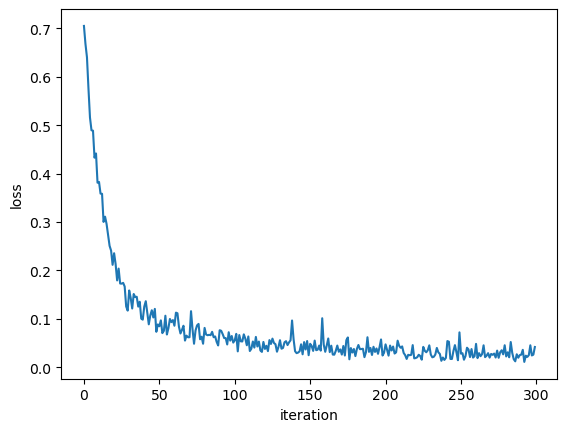

In [33]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [34]:
count = 0
max_num_of_items = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    # set model to eval
    model.eval()
    
    # make a prediction
    z = model(x_test)
    
    # find max
    _, yhat = torch.max(z.data, 1)
    
    # print mis-classified samples
    if yhat != y_test:
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= max_num_of_items:
            break
    # end if
# end for   

Sample : 101; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 131; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 213; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 242; Expected Label: tensor([1]); Obtained Label: tensor([0])


In [35]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/con

In [36]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [37]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week3.zip

--2025-06-21 17:46:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week3.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196, 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261482368 (249M) [application/zip]
Saving to: ‘concrete_data_week3.zip’

concrete_data_week3 100%[===================>] 249.37M  57.0MB/s    in 4.5s    

2025-06-21 17:47:02 (55.2 MB/s) - ‘concrete_data_week3.zip’ saved [261482368/261482368]



In [ ]:
!unzip -qq concrete_data_week3.zip

In [ ]:
num_classes = 2

image_resize = 224

batch_size_training = 100
batch_size_validation = 100

In [ ]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [ ]:
train_generator = data_generator.flow_from_directory(
    'concrete_data_week3/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

In [ ]:
validation_generator = data_generator.flow_from_directory(
    'concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

In [ ]:

model = Sequential()

In [ ]:
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

In [ ]:
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.layers

In [ ]:
model.layers[0].layers

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

In [ ]:
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

In [ ]:
model.save('classifier_resnet_model.h5')

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

In [ ]:
!unzip -qq concrete_data_week4.zip

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [ ]:
model_1 = Sequential()

In [ ]:
model_1.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

In [ ]:
num_classes = 2

image_resize = 224

batch_size_training = 100
batch_size_validation = 100

In [ ]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [ ]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
train_generator = data_generator.flow_from_directory(
    'concrete_data_week4/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

In [ ]:
validation_generator = data_generator.flow_from_directory(
    'concrete_data_week4/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

In [ ]:
model_1.add(Dense(num_classes, activation='softmax'))

In [ ]:
model_1.layers

In [ ]:

model_1.layers[0].layers

In [ ]:
model_1.summary()

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

In [ ]:
fit_history = model_1.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

In [ ]:
model_1.save('classifier_vgg16_model.h5')

In [ ]:
from keras.models import load_model

In [ ]:
model_ResNet50 = load_model('classifier_resnet_model.h5')

In [ ]:
model.summary()

In [ ]:
batch_size_test=5

In [ ]:

data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [ ]:
test_set = data_generator_test.flow_from_directory(
    'concrete_data_week4/test',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_test, shuffle=False,
    class_mode='categorical')

In [ ]:

score_ResNet50 = model.evaluate_generator(test_set,steps=len(test_set),use_multiprocessing=False)
print("Accuracy with ResNet50 = ",score_ResNet50[1])

In [ ]:
score_Vgg16 = model_1.evaluate_generator(test_set,steps=len(test_set),use_multiprocessing=False)
print("Accuracy with vgg16 = ",score_Vgg16[1])

In [ ]:
predict_VGG16 = model_1.predict_generator(test_set,steps=len(test_set), verbose=0).round(2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(0,3):
    first_batch_images = test_set.next()[0]
    
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        #image_data = first_batch_images[ind]
        image_data = first_batch_images[ind].astype(np.uint8)
        ax2.imshow(image_data)
        ind += 1

fig.suptitle('images') 
plt.show()

In [ ]:
classes = model_1.predict_classes(first_batch_images)
classes

In [ ]:
#predictions= model_1.predict_generator(test_set).round(2)

In [ ]:
predicted_class_indices_vgg16=np.argmax(predict_VGG16,axis=1)
labels = (test_set.class_indices)
labels2 = dict((v,k) for k,v in labels.items())

In [ ]:
 predict_VGG16 = [labels2[k] for k in predicted_class_indices_vgg16]

In [ ]:
print (predict_VGG16[0])
print(predict_VGG16[1])
print(predict_VGG16[2])
print(predict_VGG16[3])
print(predict_VGG16[4])

In [ ]:
predict_ResNet = model.predict_generator(test_set,steps=len(test_set), verbose=0)

In [ ]:
for i in range(0,3):
    first_batch_images = test_set.next()[0]
    
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        #image_data = first_batch_images[ind]
        image_data = first_batch_images[ind].astype(np.uint8)
        ax2.imshow(image_data)
        ind += 1

fig.suptitle('images') 
plt.show()

In [ ]:
classes = model.predict_classes(first_batch_images)
classes

In [ ]:
predicted_class_indices_ResNet50=np.argmax(predict_ResNet,axis=1)
labels = (test_set.class_indices)
labels2 = dict((v,k) for k,v in labels.items())

In [ ]:
predict_ResNet50 = [labels2[k] for k in predicted_class_indices_ResNet50]

In [ ]:

print (predict_ResNet50[0])
print(predict_ResNet50[1])
print(predict_ResNet50[2])
print(predict_ResNet50[3])
print(predict_ResNet50[4])

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.
